In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt
import os
import glob

current_folder = os.getcwd()

csv_files = glob.glob(os.path.join(current_folder, "*.csv"))

df_list = []
df_list_calibration = []
file_list = []
file_list_calibration = []


for file in csv_files:
    print(f"Processing: {file[-27:-4]}")

    
    df_header = pd.read_csv(file, delimiter=';', nrows=0)

    
    df = pd.read_csv(
        file,
        delimiter=';',
        decimal=',',
        skiprows=999,
        skipfooter=999,
        names=df_header.columns,
        engine='python'
    )
    if file.endswith('calibration.csv'):
        df_list_calibration.append(df)
        file_list_calibration.append(file)
    else:
        df_list.append(df)
        file_list.append(file)

print(f"Le nombre de fichiers 'calibration' : {len(df_list_calibration)}")

print(f"Le nombre de fichiers 'mesures' : {len(df_list)}")


Processing: 16_WL2m_4cm_calibration
Processing: L2m_10cmbis_calibration
Processing: _WL1,2m_4cm_calibration
Processing: ,2m_10cmbis_calibration
Processing: 12_WL2m_4cm_calibration
Processing: L2m_10cmbis_calibration
Processing: Pente_05_wl1,5m_hb_10cm
Processing: Pente_05_wl1,5m_h__04cm
Processing: Pente_05_wl1,5m_h__07cm
Processing: Pente_05_wl1,5m_h__10cm
Processing: Pente_05_wl2,0m_hb_10cm
Processing: Pente_05_wl2,0m_h__04cm
Processing: Pente_05_wl2,0m_h__07cm
Processing: Pente_05_wl2,0m_h__10cm
Processing: Pente_10_wl1,5m_hb_10cm
Processing: Pente_10_wl1,5m_h__04cm
Processing: Pente_10_wl1,5m_h__07cm
Processing: Pente_10_wl1,5m_h__10cm
Processing: Pente_10_wl2,0m_hb_10cm
Processing: Pente_10_wl2,0m_h__04cm
Processing: Pente_10_wl2,0m_h__07cm
Processing: Pente_10_wl2,0m_h__10cm
Le nombre de fichiers 'calibration' : 6
Le nombre de fichiers 'mesures' : 16


In [2]:
def butter_lowpass(cutoff, fs, order=4):
    nyquist = 0.5 * fs  
    normal_cutoff = cutoff / nyquist 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=4):
    b, a = butter_lowpass(cutoff, fs, order)
    return filtfilt(b, a, data)

Processing de : Pente_05_wl1,5m_h__04cm


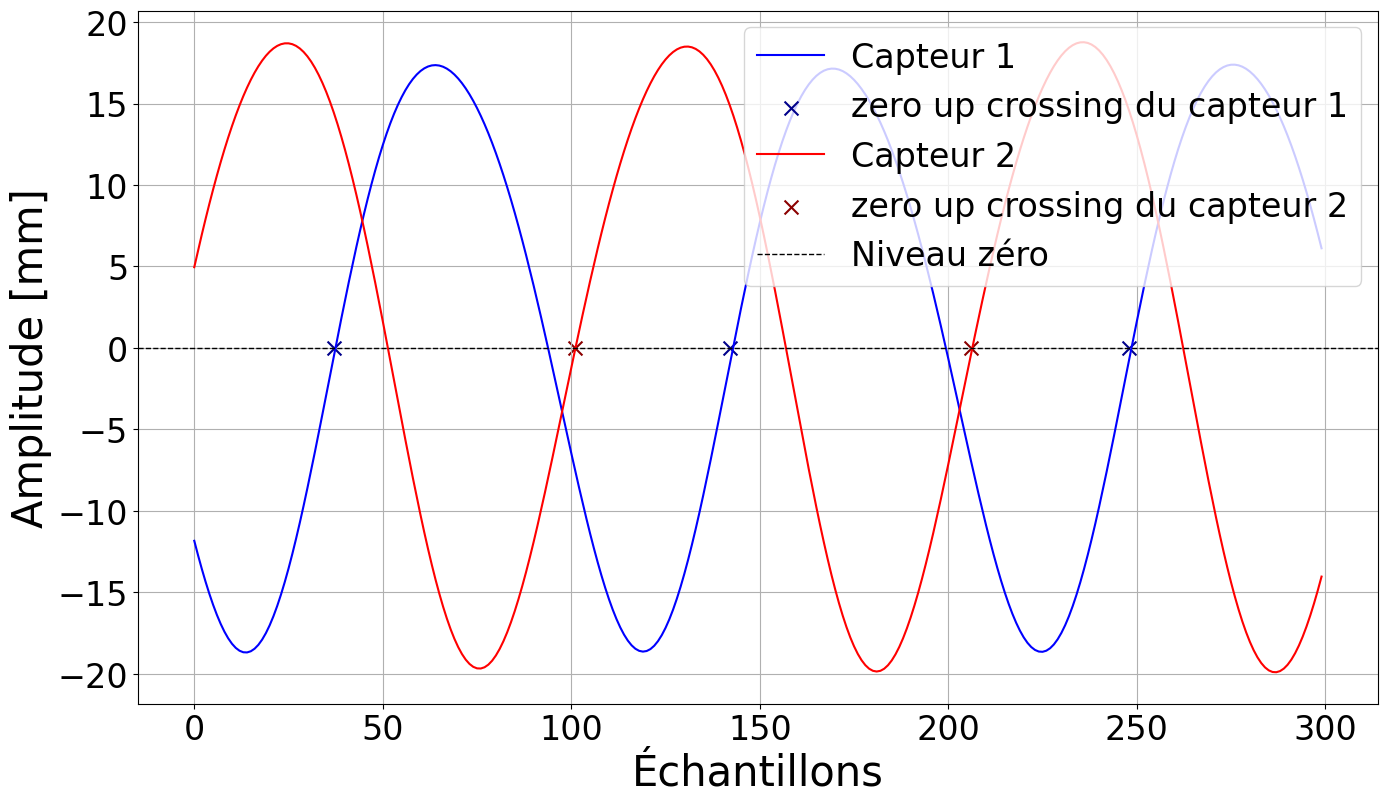

In [ ]:
for i,df in enumerate(df_list):
    valeur = 1

    if i != valeur:
        continue 
    print(f"Processing de : {file_list[valeur][-27:-4]}")
    list_sensore = ["Sensore_5[mm]","Sensore_6[mm]"]
    list_wave_heights = []
    fs=100
    cutoff = 1.7
    list_signal = []
    list_zero_up_crossing = []
    list_zero_down_crossing = []

    for j in list_sensore:
        
        dff = df.copy()[j][8000:]

        dff = dff.mask((dff < 350) | (dff > 525))
        
        df_1 = dff.interpolate(method='linear')
        df_zc = df_1.copy()[20:-20]
        df_zc = pd.DataFrame(df_zc)  
        
        df_zc['filtered_signal'] = butter_lowpass_filter(df_zc[j], cutoff, fs)

        mean_value = df_zc['filtered_signal'].mean()
        df_zc['centered_signal'] = df_zc['filtered_signal'] - mean_value
        signal = df_zc['centered_signal'].values[-1000:-700]
        list_signal.append(signal)
        zero_up_crossings = np.where((signal[:-1] < 0) & (signal[1:] >= 0))[0]
        zero_down_crossings = np.where((signal[:-1] > 0) & (signal[1:] <= 0))[0]
        list_zero_up_crossing.append(zero_up_crossings)
        list_zero_down_crossing.append(zero_down_crossings)

    signal1 = list_signal[0]
    signal2 = list_signal[1]
    plt.rcParams.update({'font.size': 24})
    plt.figure(figsize=(16, 9),facecolor='none')
    plt.plot(signal1, label='Capteur 1',color='blue')
    plt.scatter(list_zero_up_crossing[0], [0]*len(list_zero_up_crossing[0]), s=100,color='darkblue', marker='x',label='zero up crossing du capteur 1')
    plt.plot(signal2, label='Capteur 2',color='red')
    plt.scatter(list_zero_up_crossing[1], [0]*len(list_zero_up_crossing[1]), s=100,color='darkred', marker='x',label='zero up crossing du capteur 2')

    plt.axhline(0, color='k', linestyle='--', linewidth=1, label='Niveau zéro')
    #plt.title("Signaux des deux capteurs")
    plt.xlabel("Échantillons", fontsize=30)
    plt.ylabel("Amplitude [mm]", fontsize=30)
    plt.legend(loc='upper right') 
    plt.grid(True)
    plt.savefig('Zero_up_graph_Poster.png')
    plt.show()
    break

Calcul de la vitesse et de la longueur d'onde. Lorsque des valeurs aberrantes ont été observés, un calcul manuel a été effectué

In [22]:
for valeur in range(16):
    for i,df in enumerate(df_list):


        if i != valeur:
            continue 

        
        list_sensore = ["Sensore_5[mm]","Sensore_6[mm]"]
        list_wave_heights = []
        fs=100
        cutoff = 1.7
        list_signal = []
        list_zero_up_crossing = []
        list_zero_down_crossing = []

        for j in list_sensore:
            
            dff = df.copy()[j][8000:]

            dff = dff.mask((dff < 350) | (dff > 525))
            
            df_1 = dff.interpolate(method='linear')
            df_zc = df_1.copy()[20:-20]
            df_zc = pd.DataFrame(df_zc)  
            
            df_zc['filtered_signal'] = butter_lowpass_filter(df_zc[j], cutoff, fs)

            mean_value = df_zc['filtered_signal'].mean()
            df_zc['centered_signal'] = df_zc['filtered_signal'] - mean_value
            #signal = df_zc['centered_signal'].values[-3500:-2800]
            signal = df_zc['centered_signal'].values[:1000]
            list_signal.append(signal)

        signal1 = list_signal[0]
        signal2 = list_signal[1]
        


    for signal in list_signal:
            zero_up_crossings = np.where((signal[:-1] < 0) & (signal[1:] >= 0))[0]
            zero_down_crossings = np.where((signal[:-1] > 0) & (signal[1:] <= 0))[0]
            list_zero_up_crossing.append(zero_up_crossings)
            list_zero_down_crossing.append(zero_down_crossings)

    crossings_1 = list_zero_up_crossing[0]
    crossings_2 = list_zero_up_crossing[1]

    crossings_3 = list_zero_down_crossing[0]
    crossings_4 = list_zero_down_crossing[1]

    velocity = []
    for u in range(min(len(crossings_1),len(crossings_2)) - 1):
            start = crossings_1[u]
            end = crossings_2[u]
            if end-start < 0 or end-start <0:
                    end = list_zero_up_crossing[1][u+1]
            time = (end - start)/100
            velocity.append(1/time)

    for w in range(min(len(crossings_3),len(crossings_4)) - 1):
            start = crossings_3[w]
            end = crossings_4[w]
            if end-start < 0 or end-start <30:
                    end = crossings_4[w+1]

            time = (end - start)/100
            velocity.append(1/time)

    v_mean = 0
    for v in velocity:
            v_mean += v
    v_mean /= len(velocity)
    

    ### Calcul de la longueur d'onde

    t1 = crossings_1[1]
    t2 = crossings_1[2]

    t3 = crossings_3[1]
    t4 = crossings_3[2]

    time= (t2-t1) / fs
    longueur_donde = v_mean * time
    time2= (t4-t3) / fs
    longueur_donde2 = v_mean * time2
    if np.round((longueur_donde+longueur_donde2)/2,2) > 2.35 or np.round((longueur_donde+longueur_donde2)/2,2)<1.32:
          continue
    print("")
    print("-----------------------")
    print("")

    print(f"Processing de : {file_list[valeur][-27:-4]}")
    print(f"Pour la pente 1/{file_list[valeur][-21:-19]}, {file_list[valeur][-16:-12]}, {file_list[valeur][-11:-4]} : ")
    print(f"La vitesse est de : {v_mean:.2f} m/s")
    print(f"La longueur d'onde est de: {(longueur_donde+longueur_donde2)/2:.2f} m")

        

        
            



-----------------------

Processing de : Pente_05_wl1,5m_hb_10cm
Pour la pente 1/05, 1,5m, hb_10cm : 
La vitesse est de : 1.43 m/s
La longueur d'onde est de: 1.32 m

-----------------------

Processing de : Pente_05_wl1,5m_h__04cm
Pour la pente 1/05, 1,5m, h__04cm : 
La vitesse est de : 1.57 m/s
La longueur d'onde est de: 1.67 m

-----------------------

Processing de : Pente_05_wl1,5m_h__07cm
Pour la pente 1/05, 1,5m, h__07cm : 
La vitesse est de : 1.42 m/s
La longueur d'onde est de: 1.41 m

-----------------------

Processing de : Pente_05_wl1,5m_h__10cm
Pour la pente 1/05, 1,5m, h__10cm : 
La vitesse est de : 1.44 m/s
La longueur d'onde est de: 1.39 m

-----------------------

Processing de : Pente_10_wl1,5m_hb_10cm
Pour la pente 1/10, 1,5m, hb_10cm : 
La vitesse est de : 1.49 m/s
La longueur d'onde est de: 1.34 m

-----------------------

Processing de : Pente_10_wl1,5m_h__04cm
Pour la pente 1/10, 1,5m, h__04cm : 
La vitesse est de : 1.52 m/s
La longueur d'onde est de: 1.52 m

---